In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, f_oneway, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from refactoring import *

### Loading CSV into pandas dataframe for data cleaning

In [17]:
suicides = pd.read_csv('suicides.csv')

#### Initial look at the data for data cleaning

In [18]:
suicides.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z
1,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z
2,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z
3,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z
4,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z


#### Remove metadata columns and missing data to create a usable dataset for EDA

In [19]:
# Check columns to identify which columns to drop that contain missing data over 60%
suicides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               4392 non-null   object 
 1   Indicator                   4392 non-null   object 
 2   ValueType                   4392 non-null   object 
 3   ParentLocationCode          4392 non-null   object 
 4   ParentLocation              4392 non-null   object 
 5   Location type               4392 non-null   object 
 6   SpatialDimValueCode         4392 non-null   object 
 7   Location                    4392 non-null   object 
 8   Period type                 4392 non-null   object 
 9   Period                      4392 non-null   int64  
 10  IsLatestYear                4392 non-null   bool   
 11  Dim1 type                   4392 non-null   object 
 12  Dim1                        4392 non-null   object 
 13  Dim1ValueCode               4392 

In [20]:
# Drop missing data columns to clean the dataset
suicides.dropna(axis='columns', how='all', inplace=True)
suicides.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,Dim1 type,Dim1,Dim1ValueCode,Dim2 type,Dim2,Dim2ValueCode,FactValueNumeric,Value,Language,DateModified
0,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,15-24 years,YEARS15-24,0.0,0.0,EN,2021-07-06T04:00:00.000Z
1,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,25-34 years of age,YEARS25-34,0.0,0.0,EN,2021-07-06T04:00:00.000Z
2,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,35-44 years of age,YEARS35-44,0.0,0.0,EN,2021-07-06T04:00:00.000Z
3,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,45-54 years,YEARS45-54,0.0,0.0,EN,2021-07-06T04:00:00.000Z
4,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,65-74 years,YEARS65-74,0.0,0.0,EN,2021-07-06T04:00:00.000Z


In [21]:
#Check values of Dim2ValueCode to determine how to split the strings
suicides.Dim2ValueCode.value_counts()

YEARS15-24     549
YEARS25-34     549
YEARS35-44     549
YEARS45-54     549
YEARS65-74     549
YEARS75-84     549
YEARS85PLUS    549
YEARS55-64     549
Name: Dim2ValueCode, dtype: int64

In [22]:
#Replace YEARS with "" to prep for a column split
suicides['Dim2ValueCode'] = suicides['Dim2ValueCode'].replace('YEARS', '', regex=True)
print(suicides['Dim2ValueCode'].value_counts())

#Check dataframe for accurate split and new columns
suicides.head()

15-24     549
25-34     549
35-44     549
45-54     549
65-74     549
75-84     549
85PLUS    549
55-64     549
Name: Dim2ValueCode, dtype: int64


,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,Dim1 type,Dim1,Dim1ValueCode,Dim2 type,Dim2,Dim2ValueCode,FactValueNumeric,Value,Language,DateModified
0,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,15-24 years,15-24,0.0,0.0,EN,2021-07-06T04:00:00.000Z
1,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,25-34 years of age,25-34,0.0,0.0,EN,2021-07-06T04:00:00.000Z
2,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,35-44 years of age,35-44,0.0,0.0,EN,2021-07-06T04:00:00.000Z
3,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,45-54 years,45-54,0.0,0.0,EN,2021-07-06T04:00:00.000Z
4,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,65-74 years,65-74,0.0,0.0,EN,2021-07-06T04:00:00.000Z


In [23]:
# Identify columns to remove to create a clean dataset for EDA
suicide_columns = suicides.columns.to_list()
print(suicide_columns)

#Add desired columns to a list
desired_columns = ['ParentLocation', 'Location', 'Value', 'Dim1', 'Dim2ValueCode']

['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode', 'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location', 'Period type', 'Period', 'IsLatestYear', 'Dim1 type', 'Dim1', 'Dim1ValueCode', 'Dim2 type', 'Dim2', 'Dim2ValueCode', 'FactValueNumeric', 'Value', 'Language', 'DateModified']


### Chosing columns for EDA (Metadata)

-- Metadata on columns for Crude Suicide Rates (per 100 000 population)-- <br>
ParentLocation = Region ('Americas', 'Western Pacific', 'Europe', 'Africa', 'South-East Asia', 'Eastern Mediterranean') <br>
Location = Country data surveyed (Multitude) <br>
Period = Year data collected <br>
Value = Crude Suicide Rates (per 100 000 population) <br>
Sex = Gender (Male/Female/Both) <br>
AgeMin / AgeMax = Age ranges for data (Assume 100 yrs old is max)

In [24]:
suicides_clean = suicides[desired_columns].rename(columns={'Dim1': 'sex', 'Dim2ValueCode': 'age_range', 'ParentLocation': 'region', 'Location': 'country', 'Value': 'suicide_rate'})
suicides_clean.head()

,region,country,suicide_rate,sex,age_range
0,Americas,Antigua and Barbuda,0.0,Both sexes,15-24
1,Americas,Antigua and Barbuda,0.0,Both sexes,25-34
2,Americas,Antigua and Barbuda,0.0,Both sexes,35-44
3,Americas,Antigua and Barbuda,0.0,Both sexes,45-54
4,Americas,Antigua and Barbuda,0.0,Both sexes,65-74


In [25]:
# Adjust Sex column where Both sexes = Both for simplicity
suicides_clean['sex'] = suicides_clean.sex.apply(lambda sex: 'Both' if sex == 'Both sexes' else sex)

# Check for correct changes
suicides_clean.sex.value_counts()

Both      1464
Female    1464
Male      1464
Name: sex, dtype: int64

In [26]:
# Remove the redundant Both category in sexes for future EDA (Compare Male to Female only)
suicides_clean = suicides_clean[suicides_clean.sex != 'Both']
suicides_clean.head()

,region,country,suicide_rate,sex,age_range
7,Americas,Antigua and Barbuda,0.0,Female,15-24
8,Americas,Antigua and Barbuda,0.0,Female,25-34
9,Americas,Antigua and Barbuda,0.0,Female,35-44
10,Americas,Antigua and Barbuda,0.0,Female,45-54
11,Americas,Antigua and Barbuda,0.0,Female,65-74


### Check/adjust data types to complete data cleaning

In [66]:
missing_data_check(suicides_clean)

NameError: name 'missing_data_check' is not defined

### Univariate Data Profiling

Initial summary statistics to get a general picture of the data. <br>
Also to generate questions to answer using the data and potential model building

In [29]:
suicides_clean.describe()

,suicide_rate
count,2928.000000
mean,24.101752
std,48.511200
min,0.000000
25%,4.227500
50%,10.080000
75%,23.395000
max,646.000000


##### Mean suicide rates by region

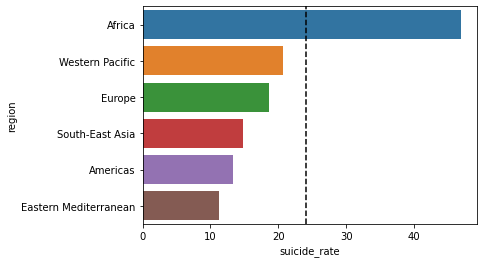

In [30]:
# Visualization of the choosen summary stat to identify trends 
summary_stats_barplot(suicides_clean, np.mean, value='suicide_rate', category='region')

Africa mean suicide rates exceed all other regions and the total average by nearly double or more<br>

##### Median suicide rates by region

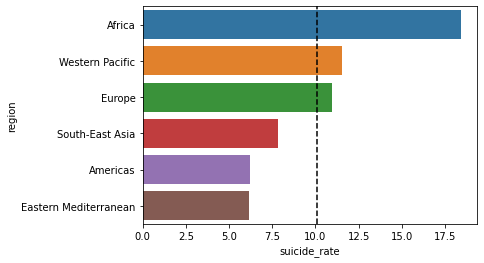

In [31]:
# Visualization of the medians to identify trends
summary_stats_barplot(suicides_clean, np.median, value='suicide_rate', category='region')

Africa median suicide rates exceeds all other regions but not to the extent of the mean suicide rates<br>
Median is more resistant summary statistic to outliers which can explain the differences<br>
The presence of outliers will have to be explored with histograms/boxplots

<AxesSubplot:xlabel='suicide_rate', ylabel='Count'>

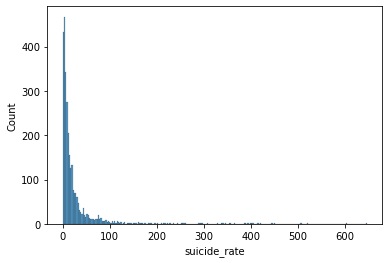

In [32]:
#Histogram to visualize the spread of the suicide rates of all countries together
sns.histplot(data=suicides_clean, x='suicide_rate')

Coarse search reveals right skewed spread due to outliers (All countries) <br>

#### Are the suicide rates skewed for each region?

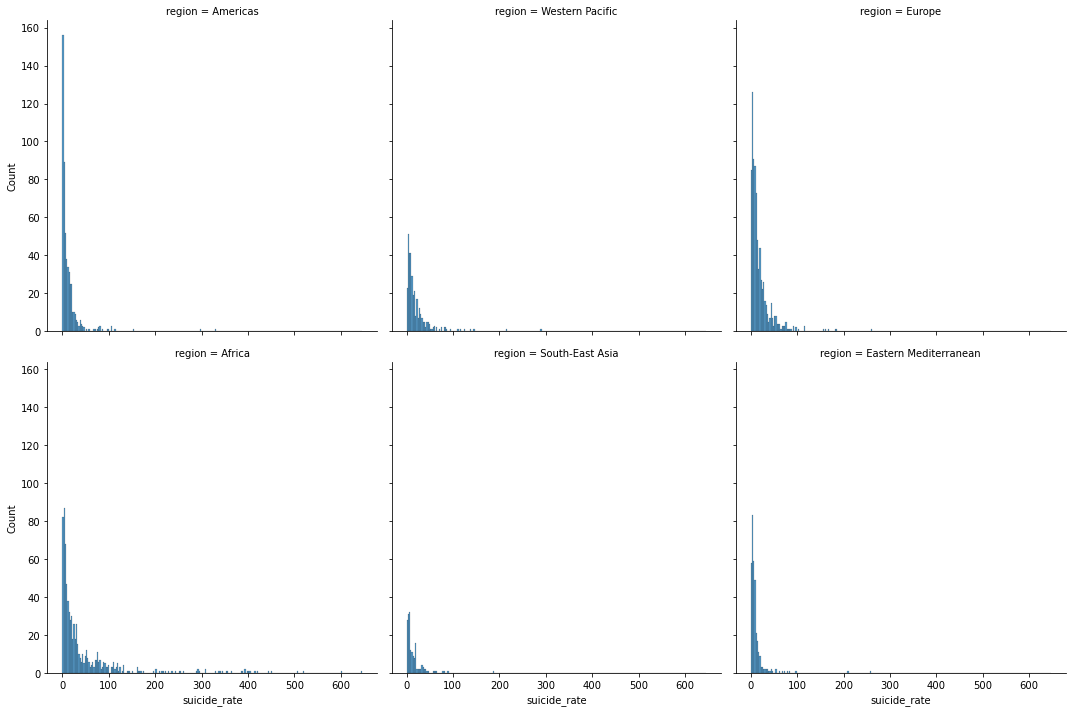

In [33]:
#Figure level plot to aid visualization
sns.displot(data=suicides_clean, x='suicide_rate', col='region', col_wrap=3)

Spread is still right skewed at the region level <br>
An indepth look at the IQR, median and range is needed

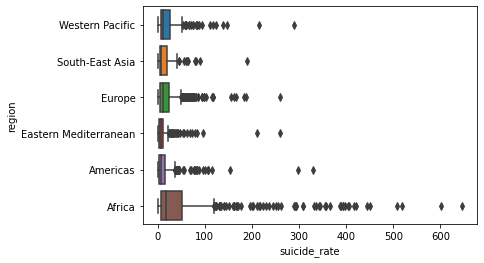

In [34]:
sorted_boxplot(suicides_clean, 'region', 'suicide_rate')

Africa appears to have the largest range for suicide rates <br>
The IQR and median is higher than other regions as well

#### Distribution of Suicide Rates by Age Range

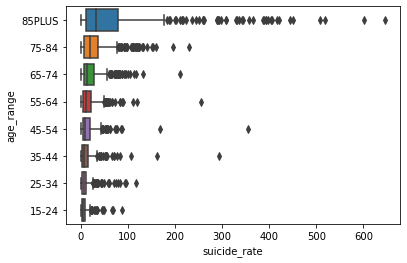

In [35]:
sorted_boxplot(suicides_clean, 'age_range', 'suicide_rate')

85Plus age range has the largest range and median<br>
All of the age ranges have a right skewed distribution that will need to be transformed for future EDA

#### Distribution of Suicide Rates by Sex

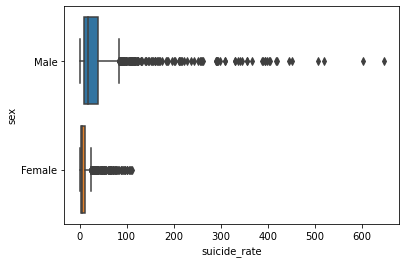

In [36]:
sorted_boxplot(suicides_clean, 'sex', 'suicide_rate')

<AxesSubplot:xlabel='suicide_rate', ylabel='Count'>

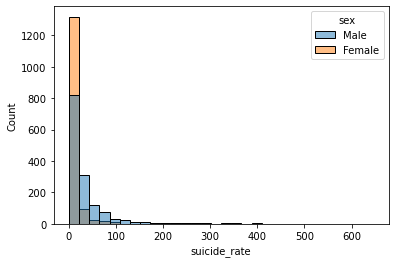

In [37]:
# Histogram to view overlap of suicide rates of males vs females
sns.histplot(data=suicides_clean, x='suicide_rate', hue='sex', bins=30)

Female distribution is concentrated closer to zero<br>
Males have a larger distribution and is skewed more heavily to the right than females

### Are the suicide rates for each region statiscally different?<br>
Null Hypothesis - The suicides rates means do not differ between regions<br>
Alt Hypothesis - Suicide rates are not equal between the regions

#### One way ANOVA Test<br>

##### ANOVA Assumptions<br>
--- Taken from codecademy ---<br>
(1) All observations should be independently and randomly sampled<br>
(2) The standard deviations of the groups should be equal<br>
(3) The data should be normally distributed or the sample size should be large<br>
(4) The groups created by the categorical variable should be independent<br>
-------------------------------- <br>
Signifcance Threshold = 0.05

In [38]:
# Checking for sample sizes between regions. Ideally sample sizes between categories should be close
suicides_clean.region.value_counts()

Europe                   800
Africa                   752
Americas                 528
Eastern Mediterranean    336
Western Pacific          336
South-East Asia          176
Name: region, dtype: int64

In [39]:
#Calculating std of each region to check if assumption 2 is met (std of groups should be equal)
column_std(suicides_clean, 'region', 'suicide_rate')

Eastern Mediterranean 21.408601472135317
Europe 23.758062090561335
Africa 81.88833938903966
Western Pacific 28.426545602541825
South-East Asia 20.393718864637474
Americas 25.816426257329482


#### Zscore Normalization

In [40]:
#Use the zscore of the value column to reduce the effects of outliers on assumptions 2 and 3
suicides_zscored = zscore_normalization(suicides_clean, 'suicide_rate')

53 rows removed


In [41]:
#Checking std difference after zscore to meet ANOVA assumption 2
column_std(suicides_zscored, 'region', 'suicide_rate')

Eastern Mediterranean 12.522337104637884
Europe 20.58785978358125
Africa 33.88010175022612
Western Pacific 21.93085331733874
South-East Asia 15.621246053459565
Americas 17.96335675137849


<AxesSubplot:xlabel='suicide_rate', ylabel='region'>

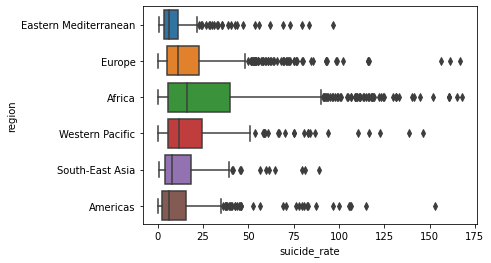

In [42]:
#Visualization of zcored distribution for assumption 3
sns.boxplot(data=suicides_zscored, x='suicide_rate', y='region')

Zscored boxplot of suicide rates  ----<br> 
It's easier to see Africa has a larger median, IQR and range<br>
The Eastern Mediterranean appears to have the lowest suicide rates

#### Zscore normalization ANOVA Test

In [43]:
#Anova test to determine if the pval is significant
anova_test(suicides_zscored, 'region', 'suicide_rate')

2.613614708541573e-50


In [44]:
#Tukey's Range Test to determine which pairings are significant
tukeys_test(suicides_zscored, 'region', 'suicide_rate')

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                group2        meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------
               Africa              Americas -17.4895    0.0 -21.3336 -13.6454   True
               Africa Eastern Mediterranean -19.8074    0.0 -24.2407 -15.3742   True
               Africa                Europe -11.7295    0.0 -15.1781   -8.281   True
               Africa       South-East Asia -15.8946    0.0 -21.5331 -10.2562   True
               Africa       Western Pacific -10.3511    0.0 -14.7844  -5.9179   True
             Americas Eastern Mediterranean  -2.3179 0.7184  -6.9916   2.3558  False
             Americas                Europe   5.7599 0.0002   2.0073   9.5126   True
             Americas       South-East Asia   1.5948 0.9709  -4.2345   7.4242  False
             Americas       Western Pacific   7.1383 0.0002   2.4

##### Africa is significantly different from every other region<br>
Region pairs that are not significantly different are: (pval >= 0.05)<br>
Americas - Eastern Mediterranean<br>
Americas - South-East Asia<br>
Eastern Mediterranean - South-East Asia<br>
Europe - South-East Asia<br>
Europe - Western Pacific<br>


The Zscored Suicide Rates ANOVA test results should be used with caution. Assumption 2 and 3 are not closely followed even after the removal of outliers.<br>
A Natural Log (ln) standarization of suicide rates should be tested for comparison

### Natural Log Transformation

Useful to transform right skewed data into a more normal distribution<br>
Cannot be used with negative values or zero as the ln of a negative = undefined

In [45]:
# ln transformation for data profiling and ANOVA test
suicides_ln = ln_transformation(suicides_clean, 'suicide_rate')

76 records removed


#### Suicide Rate by Region (ln)

In [46]:
#Calculating std of each region to check if assumption 2 is met (std of groups should be equal)
column_std(suicides_ln, 'region', 'suicide_rate')

Eastern Mediterranean 0.9898673194838148
Europe 1.057949819566598
Africa 1.43534968467717
Western Pacific 1.009008235965882
South-East Asia 1.1178408742569952
Americas 1.1493583883434237


<AxesSubplot:xlabel='suicide_rate', ylabel='region'>

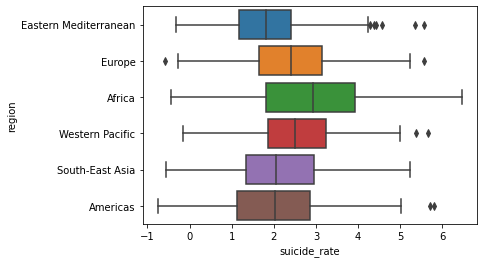

In [47]:
#Visualization of ln transformation distribution for assumption 3
sns.boxplot(data=suicides_ln, x='suicide_rate', y='region')

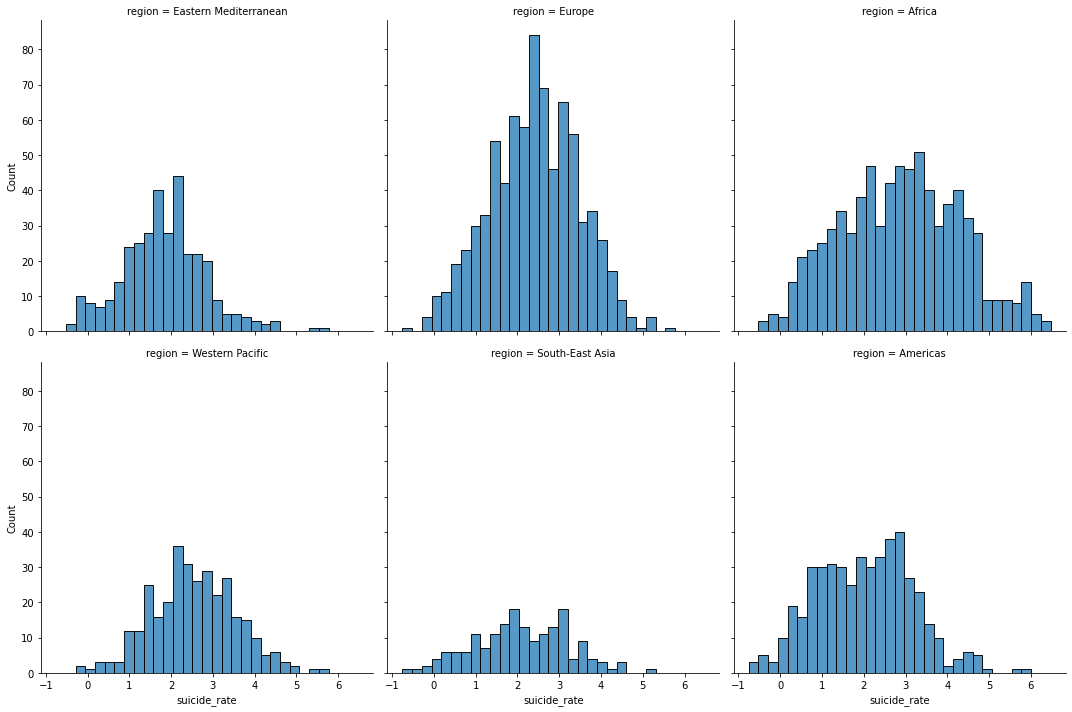

In [48]:
sns.displot(data=suicides_ln, x='suicide_rate', col='region', col_wrap=3)

Distribution for each region normalized compared to clean dataset<br>
Suicide Rates = e^Value

#### Suicide Rate by Age Range(ln)

In [49]:
#Calculating std of each age range to check if assumption 2 is met (std of groups should be equal)
column_std(suicides_ln, 'age_range', 'suicide_rate')

45-54 1.0476237409418765
55-64 1.0888552278520498
25-34 0.9924794295946477
65-74 1.0966337880893084
35-44 1.0313104189269289
85PLUS 1.34389600374223
15-24 0.928128257896598
75-84 1.1435960545769892


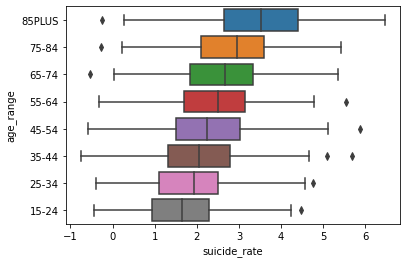

In [50]:
#Visualization of ln transformation distribution for assumption 3
sorted_boxplot(suicides_ln, 'age_range', 'suicide_rate')

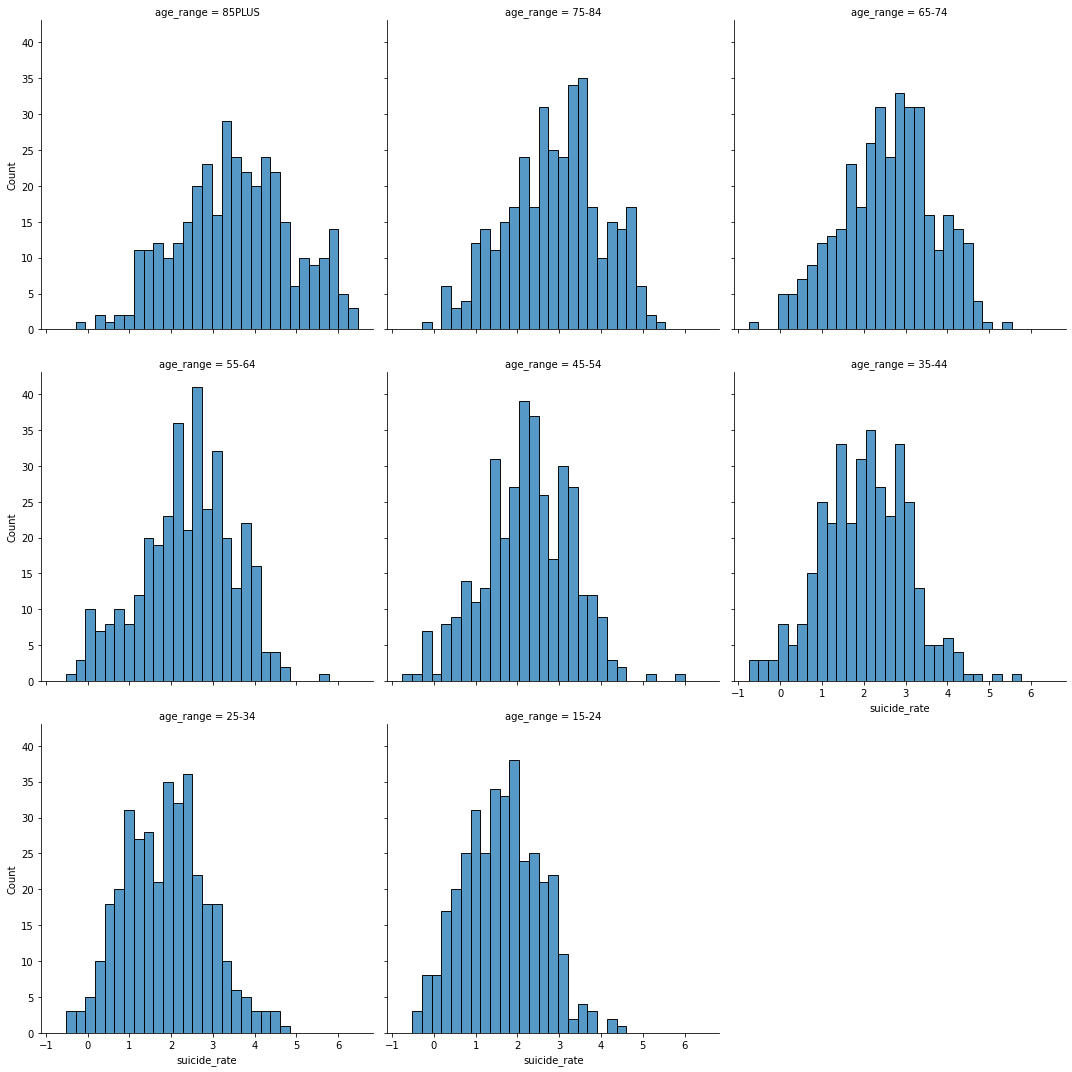

In [51]:
sns.displot(data=suicides_ln, x='suicide_rate', col='age_range', col_wrap=3)

Age range distributions are normalized<br>
Suicide Rates = e^Value

#### Suicide Rate by Sex(ln)

In [52]:
#Calculating std of each sex to check if assumption 2 is met (std of groups should be equal)
column_std(suicides_ln, 'sex', 'suicide_rate')

Male 1.0355875525978837
Female 1.040580369030891


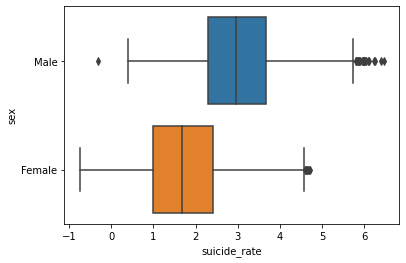

In [53]:
#Visualization of ln transformation distribution for assumption 3
sorted_boxplot(suicides_ln, 'sex', 'suicide_rate')

<AxesSubplot:xlabel='suicide_rate', ylabel='Count'>

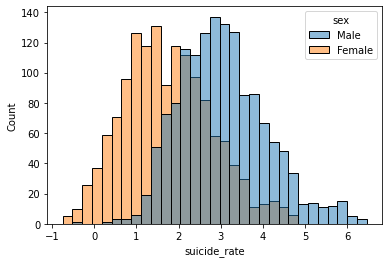

In [54]:
# Histogram to view overlap of suicide rates of males vs females
sns.histplot(data=suicides_ln, x='suicide_rate', hue='sex')

Slightly left skewed distributions<br>
Female distribution centered around Suicide Rates = e^1.5<br>
Male distribution centered around Suicide Rates = e^3

### Natural log transformation ANOVA Tests

#### ANOVA Test Suicide Rates by Region

In [55]:
#Anova test to determine if the pval is significant
anova_test(suicides_ln, 'region', 'suicide_rate')

1.1753090998849108e-52


In [56]:
#Tukey's Range Test to determine which pairings are significant
tukeys_test(suicides_ln, 'region', 'suicide_rate')

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
               Africa              Americas  -0.8569   -0.0 -1.0539 -0.6598   True
               Africa Eastern Mediterranean  -1.0334   -0.0 -1.2533 -0.8135   True
               Africa                Europe  -0.4773   -0.0 -0.6479 -0.3066   True
               Africa       South-East Asia    -0.78   -0.0 -1.0606 -0.4994   True
               Africa       Western Pacific   -0.335 0.0003  -0.557  -0.113   True
             Americas Eastern Mediterranean  -0.1766 0.2855 -0.4159  0.0628  False
             Americas                Europe   0.3796    0.0  0.1846  0.5746   True
             Americas       South-East Asia   0.0769 0.9768 -0.2192  0.3729  False
             Americas       Western Pacific   0.5219    0.0  0.2806  0.7631   True
East

##### Africa is significantly different from every other region<br>
Region pairs that are not significantly different are: (pval >= 0.05)<br>
Americas - Eastern Mediterranean<br>
Americas - South-East Asia<br>
Eastern Mediterranean - South-East Asia<br>
Europe - South-East Asia<br>
Europe - Western Pacific<br>
Natural Log transformation ANOVA test supports the results from the zscored normalized ANOVA test

#### ANOVA Test Suicide Rates by Age Range

In [57]:
#Anova test to determine if the pval is significant
anova_test(suicides_ln, 'age_range', 'suicide_rate')

2.074709176666932e-143


In [58]:
#Tukey's Range Test to determine which pairings are significant
tukeys_test(suicides_ln, 'age_range', 'suicide_rate')

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 15-24  25-34   0.2531 0.0403  0.0059 0.5003   True
 15-24  35-44   0.4073    0.0  0.1601 0.6545   True
 15-24  45-54   0.6081    0.0  0.3611 0.8551   True
 15-24  55-64   0.7729   -0.0  0.5255 1.0202   True
 15-24  65-74   0.9674   -0.0  0.7201 1.2148   True
 15-24  75-84   1.2617   -0.0   1.014 1.5094   True
 15-24 85PLUS   1.9064   -0.0   1.658 2.1549   True
 25-34  35-44   0.1542 0.5556 -0.0928 0.4012  False
 25-34  45-54    0.355 0.0004  0.1081 0.6018   True
 25-34  55-64   0.5198    0.0  0.2726 0.7669   True
 25-34  65-74   0.7143   -0.0  0.4671 0.9615   True
 25-34  75-84   1.0086   -0.0   0.761 1.2561   True
 25-34 85PLUS   1.6533   -0.0  1.4051 1.9016   True
 35-44  45-54   0.2008 0.2099  -0.046 0.4476  False
 35-44  55-64   0.3656 0.0002  0.1184 0.6128   True
 35-44  65-74   0.5601    0.0   0.313 0.8073   True
 35-44  75-8

Age range pairs that are not significantly different are: (pval >= 0.05)<br>
25-34 - 35-44<br>
35-44 - 45-54<br>
45-54 - 55-64<br>
55-64 - 65-74<br>
A trend of age ranges that are close to each other appear to not be significantly different from each other except for 85PLUS<br>

#### ANOVA Test Suicide Rates by Sex

In [59]:
#2 Sample T test to determine if the pval is significant
two_tail_ttest(suicides_ln, 'sex', 'suicide_rate')

1.417529953282241e-209


Pval <= 0.05 indicates we reject the null hypothesis<br>
The two suicide rates are not from the same population and have different means than the population